In [164]:

import math
import pandas as pd
import seaborn as sns

sns.set_palette("muted")
sns.set_style("darkgrid")

from sklearn.cluster import KMeans
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
from IPython.display import Image
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [165]:
def inspect_col_names(xls_name):
    #print data dictionary after file is loaded
    f = open('../../data/{0}.des'.format(xls_name), 'r')
    file_contents = f.read()
    print(file_contents)
    return None

In [166]:
inspect_col_names(xls_name='RENTAL')

RENTAL.DES

city      year      pop       enroll    rent      rnthsg    tothsg    avginc   
lenroll   lpop      lrent     ltothsg   lrnthsg   lavginc   clenroll  clpop    
clrent    cltothsg  clrnthsg  clavginc  pctstu    cpctstu   y90       

  Obs:   128

  1. city                     city label, 1 to 64
  2. year                     80 or 90
  3. pop                      city population
  4. enroll                   # college students enrolled
  5. rent                     average rent
  6. rnthsg                   renter occupied units
  7. tothsg                   occupied housing units
  8. avginc                   per capita income
  9. lenroll                  log(enroll)
 10. lpop                     log(pop)
 11. lrent                    log(rent)
 12. ltothsg                  log(tothsg)
 13. lrnthsg                  log(rnthsg)
 14. lavginc                  log(avginc)
 15. clenroll                 change in lrent from 80 to 90
 16. clpop                    change in lpop
 

In [167]:

def rename_cols_and_save(xls_name):
    df = pd.read_excel("../../data/{0}.xls".format(xls_name), index_col=None, header=None)
    if xls_name == 'hprice1':
        names_dict = {0:'price', 
                     1:'assess', 
                     2:'bdrms',
                     3:'lotsize', 
                     4:'sqrft', 
                     5:'colonial',
                     6:'lprice', 
                     7:'lassess', 
                     8:'llotsize',
                     9:'lsqrft', 
                    }
    elif xls_name == 'saving':
         names_dict = {0:'sav', 
                     1:'inc', 
                     2:'size',
                     3:'edu', 
                     4:'age', 
                     5:'black',
                     6:'cons', 
                      }
    elif xls_name == '401k':    
        names_dict = {0:'prate', 
                     1:'mrate', 
                     2:'totpart',
                     3:'totelg', 
                     4:'age', 
                     5:'totemp',
                     6:'sole', 
                     7:'ltotemp', 
                      }
        
    elif xls_name == '401ksubs': 
        names_dict = {0:'e401k', 
                     1:'inc', 
                     2:'marr',
                     3:'male', 
                     4:'age', 
                     5:'fsize',
                     6:'nettfa', 
                     7:'p401k',
                     8:'pira',
                     9:'incsq', 
                     10:'agesq',
                      }
    elif xls_name == 'INTDEF':
             names_dict = {0:'year', 
                     1:'i3', 
                     2:'inf',
                     3:'rec', 
                     4:'out', 
                     5:'def',
                     6:'i3_1', 
                     7:'inf_1',
                     8:'def_1',
                     9:'ci3', 
                     10:'cinf',
                     11:'cdef', 
                     12:'y77',
                      }
            
      
            
            
    elif xls_name == 'rental':
             names_dict = {0:'city', 
                     1:'year',
                     2: 'pop',
                     3:'enroll',
                     4:'rent', 
                     5:'rnthsg', 
                     6:'tothsg',
                     7:'avginc', 
                     8:'lenroll',
                     9:'lpop',
                     10:'lrent', 
                     11:'ltothsg',
                     12:'lrnthsg', 
                     13:'lavginc',
                     14:'clenroll', 
                     15:'clpop',
                     16:'clrent', 
                     17:'cltothsg', 
                     18:'clrnthsg',
                     19:'clavginc', 
                     20:'pctstu',
                     21:'cpctstu',
                     22:'y90', 
                      }
        
        
        
    df.rename(columns = names_dict, inplace = True)
    df = df.replace('.', pd.np.nan)
    df.to_csv("../../data/{0}.csv".format(xls_name), index=False)
    
    
    return df

In [168]:
df = rename_cols_and_save(xls_name='rental')

In [169]:
df.head()

,city,year,pop,enroll,rent,rnthsg,tothsg,avginc,lenroll,lpop,...,lavginc,clenroll,clpop,clrent,cltothsg,clrnthsg,clavginc,pctstu,cpctstu,y90
0,1,80,75211,15303,197,13475,26167,11537,9.635804,11.22805,...,9.353314,NaN,NaN,NaN,NaN,NaN,NaN,20.34676,NaN,0
1,1,90,77759,18017,342,15660,29467,19568,9.799071,11.26137,...,9.881651,-15293.2,0.033317,0.551607,0.118772,0.150273,0.528336,23.17031,2.823551,1
2,2,80,106743,22462,323,14580,37277,19841,10.019580,11.57818,...,9.895506,NaN,NaN,NaN,NaN,NaN,NaN,21.04307,NaN,0
3,2,90,141865,29769,496,26895,55540,31885,10.301220,11.86263,...,10.369890,-22451.7,0.284452,0.428924,0.398727,0.612289,0.474385,20.98403,-0.059032,1
4,3,80,36608,11847,216,7026,13482,11455,9.379830,10.50802,...,9.346182,NaN,NaN,NaN,NaN,NaN,NaN,32.36178,NaN,0


## Cleaning Data

In [170]:
def change_var_types(df, change_to_numeric=[], change_to_bool=[], change_to_category=[]):
    if change_to_numeric:
        for col in change_to_numeric:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    if change_to_bool:
        for var in change_to_bool:
            df[var] = df[var].astype('bool')
    if change_to_category:
        for feature in change_to_category:
            df[feature] = df[var].astype('category')
    return df

In [171]:
df = change_var_types(df=df, 
                 change_to_numeric=['clenroll', 'clpop', 'clrent', 'cltothsg', 'clrnthsg', 'cpctstu'],
                 change_to_bool=['y90'],
                 change_to_category=['year']
                
                )

In [172]:
df.dtypes

city           int64
year        category
pop            int64
enroll         int64
rent           int64
rnthsg         int64
tothsg         int64
avginc         int64
lenroll      float64
lpop         float64
lrent        float64
ltothsg      float64
lrnthsg      float64
lavginc      float64
clenroll     float64
clpop        float64
clrent       float64
cltothsg     float64
clrnthsg     float64
clavginc     float64
pctstu       float64
cpctstu      float64
y90             bool
dtype: object

## Exploratory Data Analysis

In [173]:
class EDA(object):
    
    def __init__(self, df, y):
        self.df = df
        self.y_string = y
        self.y = df[y]
        return None
    
    
    def inspect(self):
        inspect = {}
        inspect['head'] = self.df.head()
        inspect['describe'] = self.df.describe().T
        inspect['dtypes'] = self.df.dtypes
        return inspect
        
        return inspect 
    
    def _dist_plot(self, df, var):
        plt.figure()
        sns_plot = sns.distplot(df[var].dropna(), color='b').get_figure()
        sns_plot.savefig("dist_plot_{0}.png".format(var))
        return sns_plot
    
    
    def variation(self):
        numerical = self.df.select_dtypes(include=np.number)
        for col in numerical.columns: 
            self._dist_plot(df=numerical, var=col)   
        return None
    
    
    def _scatter_matrix(self):
        numerical = self.df.select_dtypes(include=np.number)
        plt.figure()
        sns_plot = sns.pairplot(numerical)
        sns_plot.savefig("scatter_matrix_plot.png".format())
        return None
    
    def _box_plot(self, var_x):
        plt.figure()
        sns_plot = sns.boxplot(x=var_x, y=self.y, data=self.df).get_figure()
        sns_plot.savefig("box_plot_{0}_{1}.png".format(var_x, self.y_string))
        return None
    
    def _scatter_plot(self, var_x):
        sns_plot = sns.lmplot(x=var_x, y=self.y_string, data=self.df)
        sns_plot.savefig("correlation_{0}_{1}.png".format(var_x, self.y_string))
        return None
    
    def covariation(self):
        self._scatter_matrix()
        
        categorical = self.df.select_dtypes(include=['bool', 'category']) 
        for col in categorical.columns:
            self._box_plot(var_x = col)
         
        numerical = self.df.select_dtypes(include=np.number)
        for col in numerical.columns:
            self._scatter_plot(var_x=col)
        return None
    
    def run(self):
        self.variation()
        self.covariation()
        return None
    
    pass

In [174]:
eda = EDA(df, y='lrent')

/Users/jjespinoza/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/Users/jjespinoza/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

/Users/jjespinoza/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



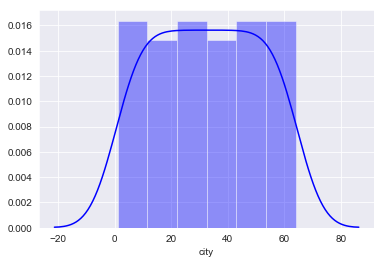

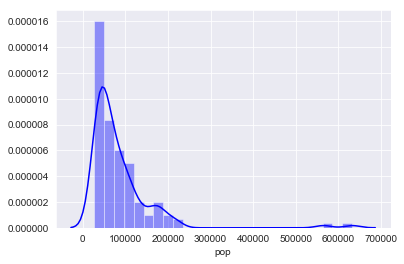

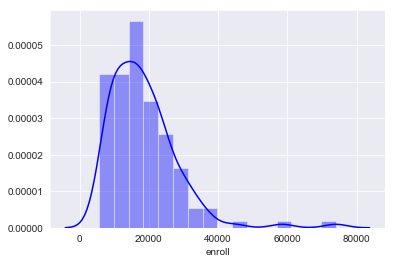

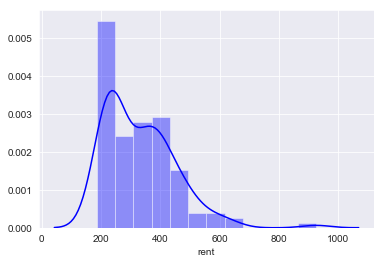

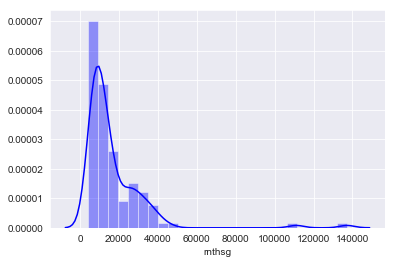

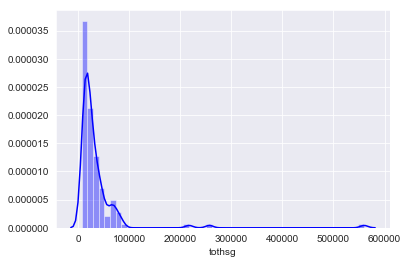

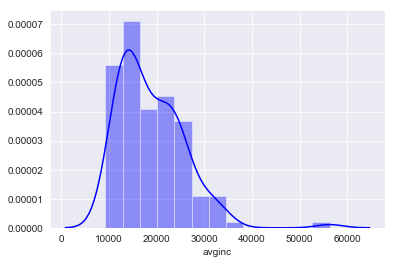

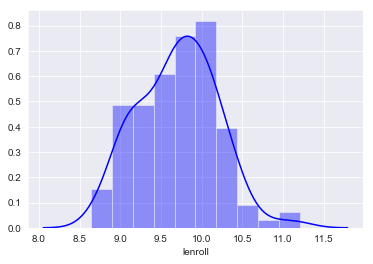

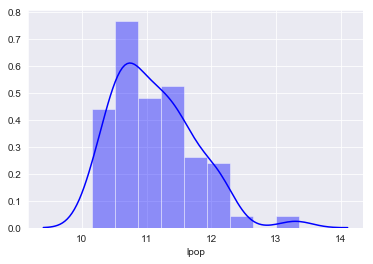

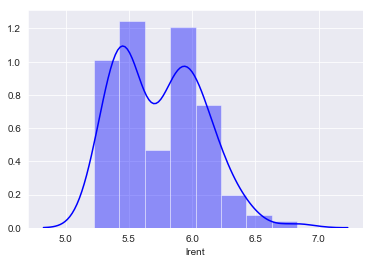

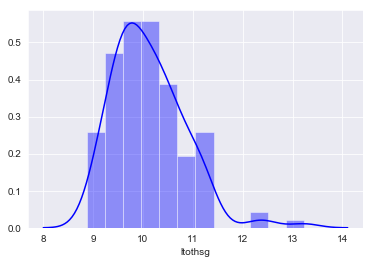

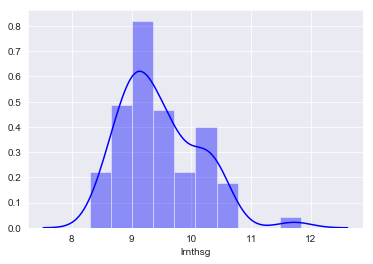

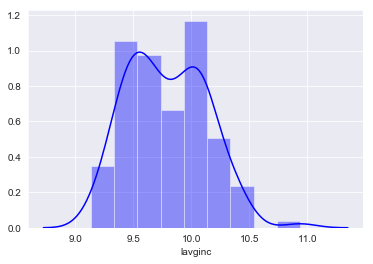

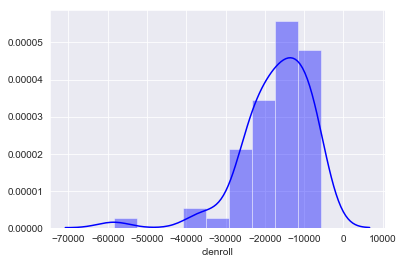

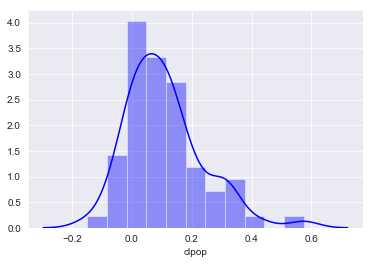

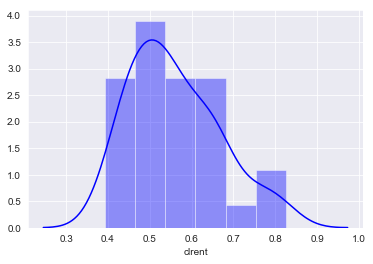

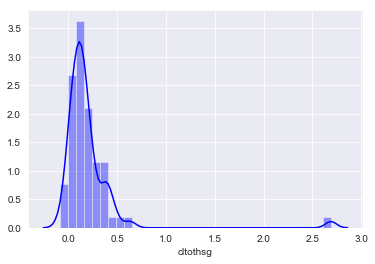

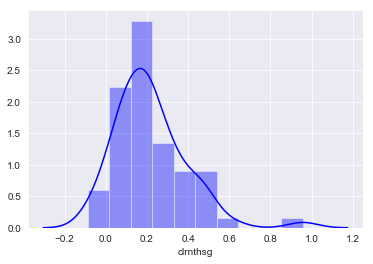

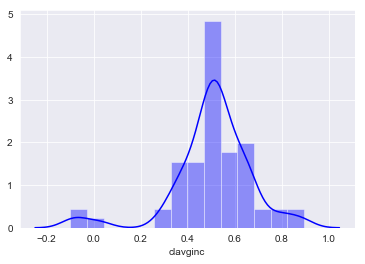

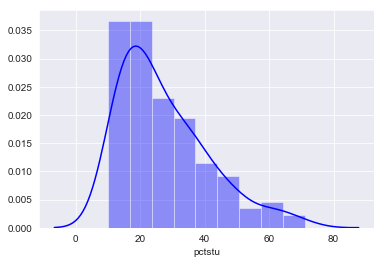

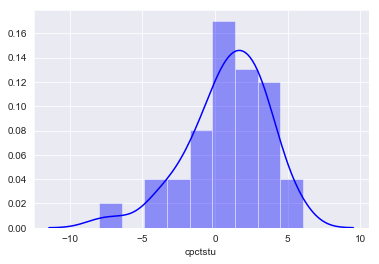

<Figure size 432x288 with 0 Axes>

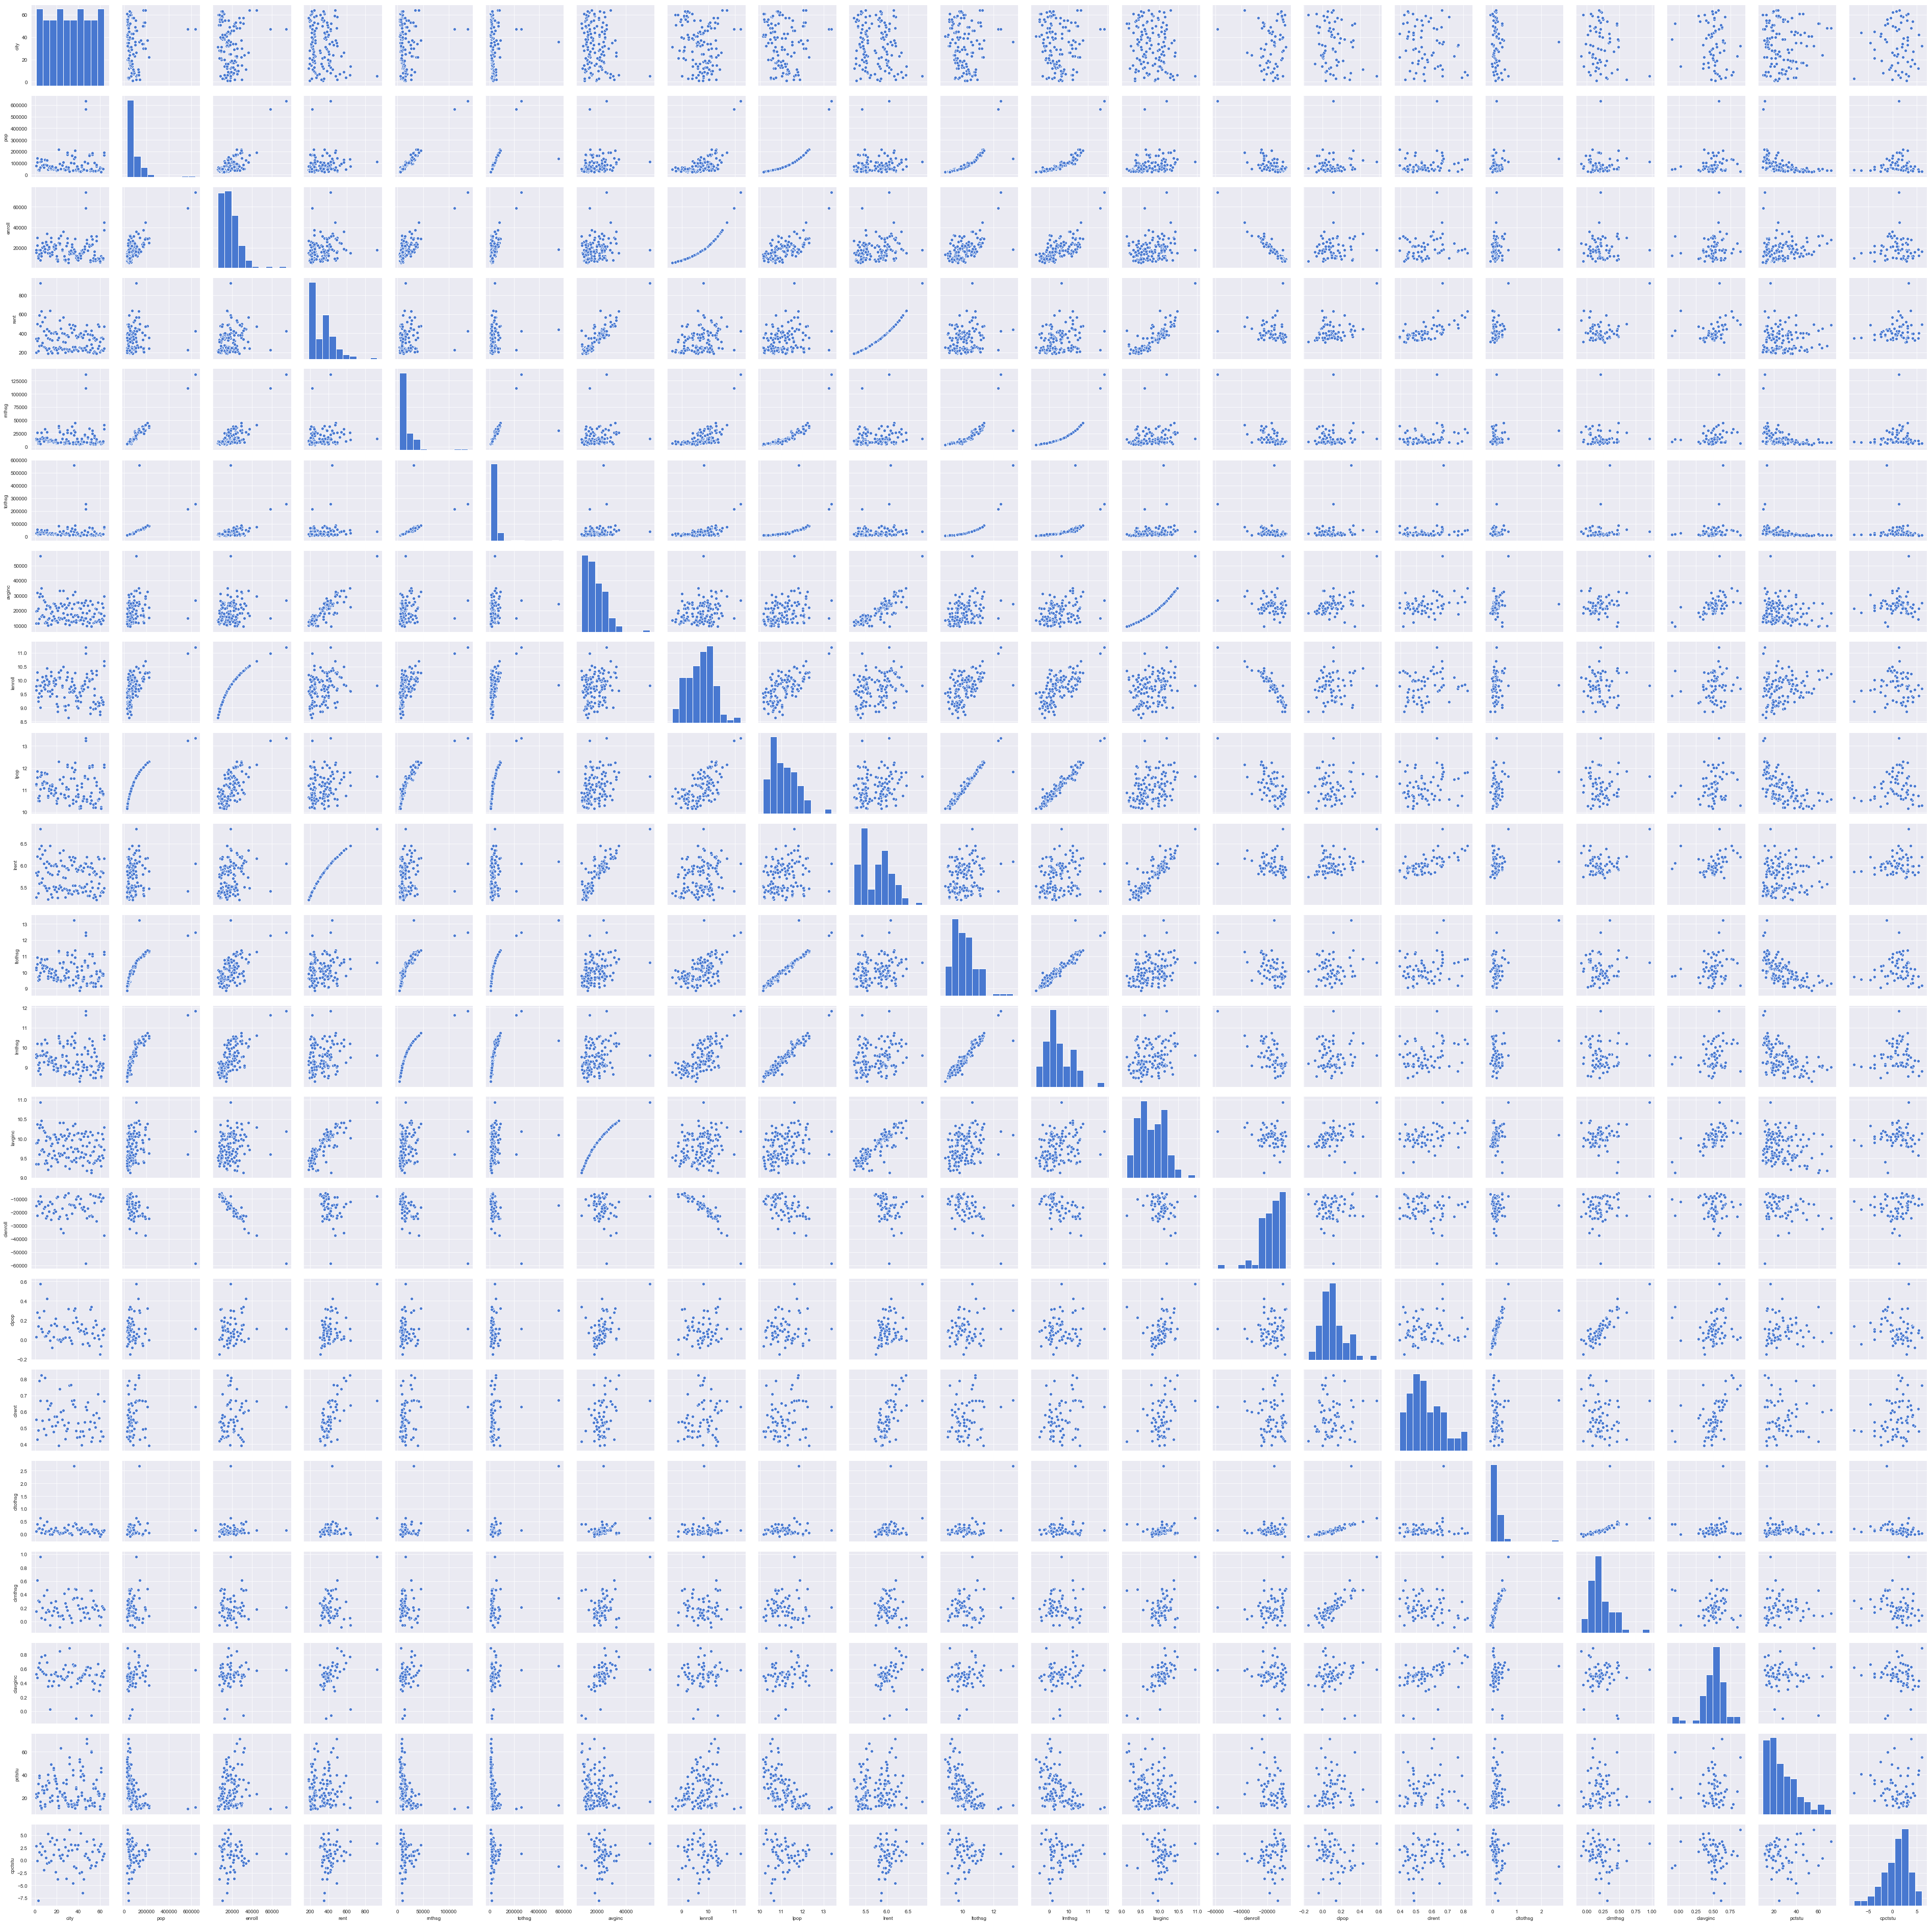

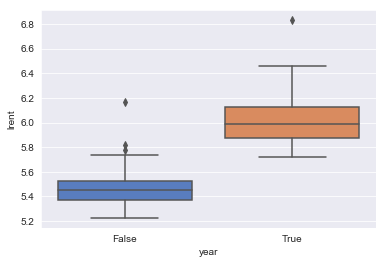

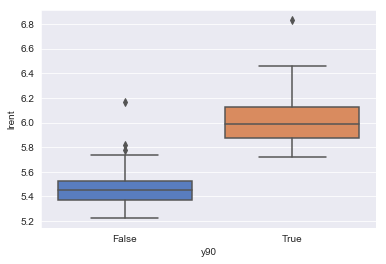

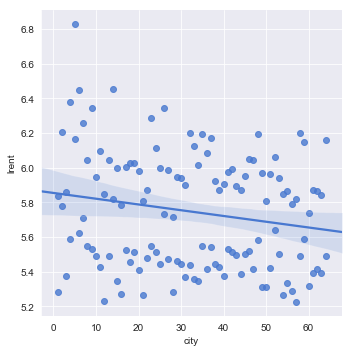

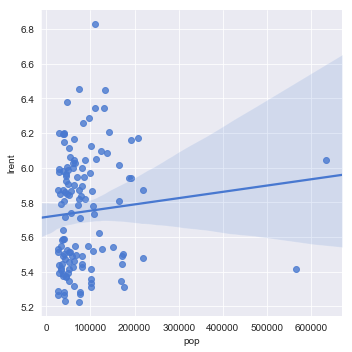

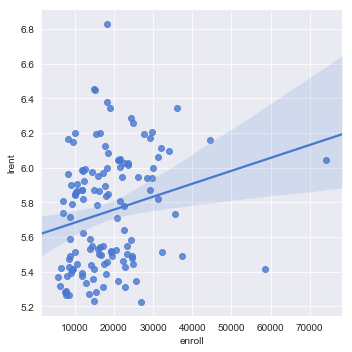

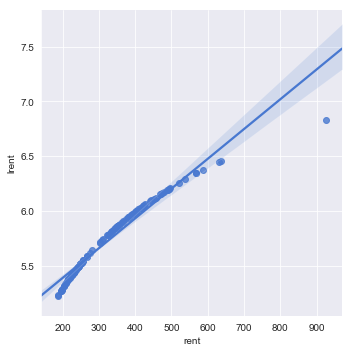

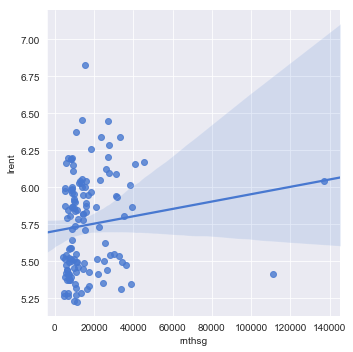

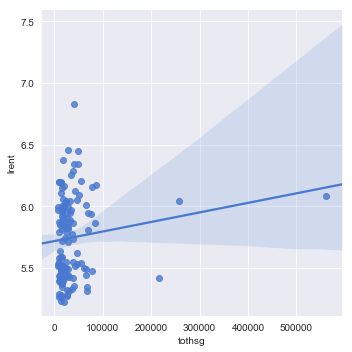

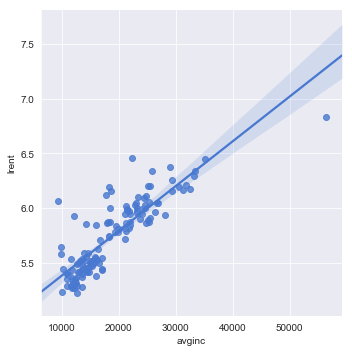

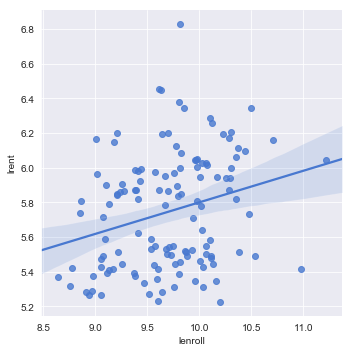

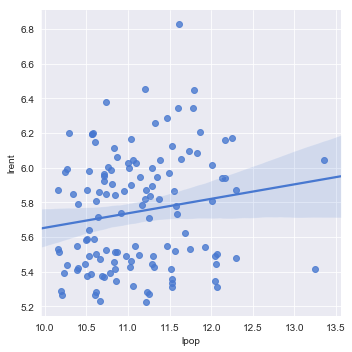

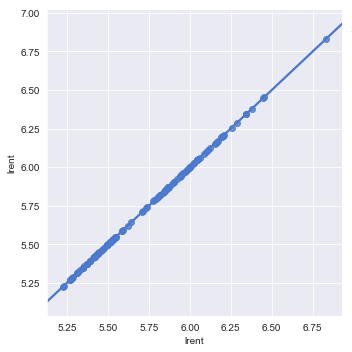

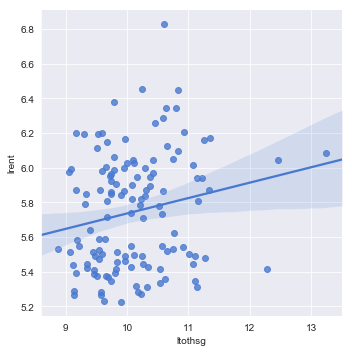

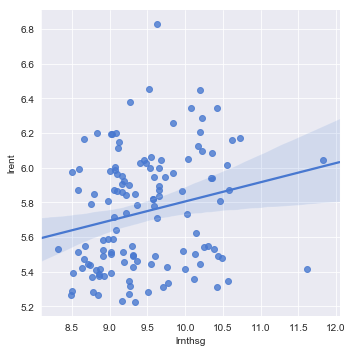

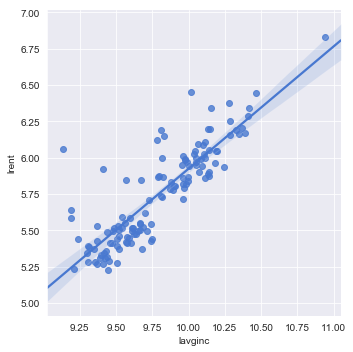

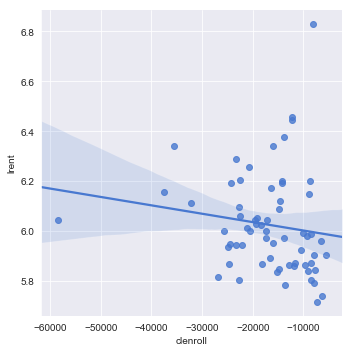

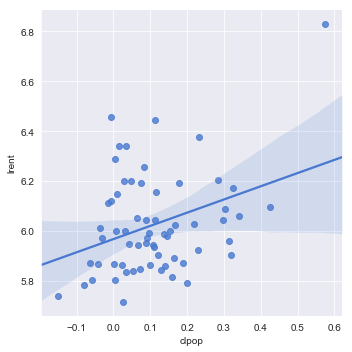

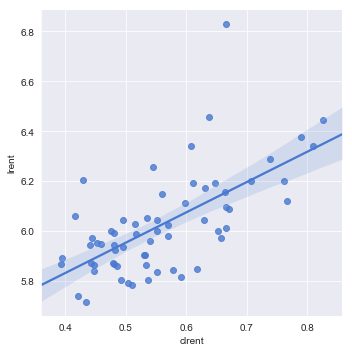

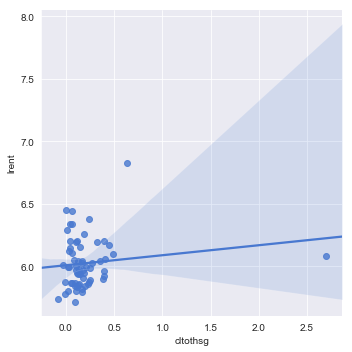

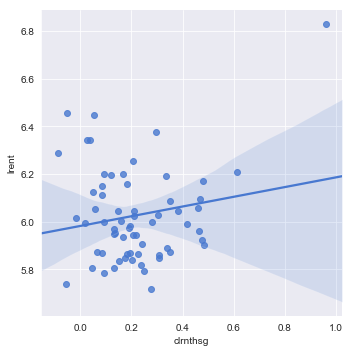

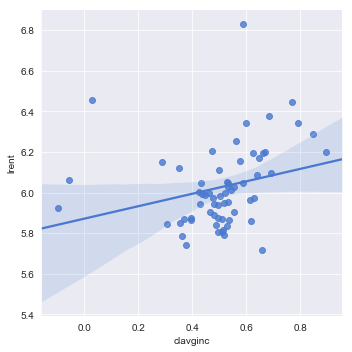

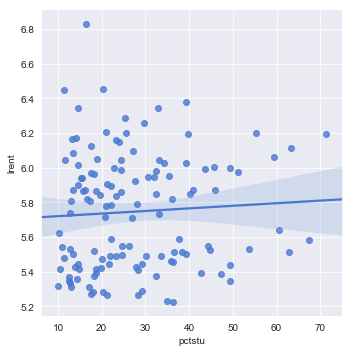

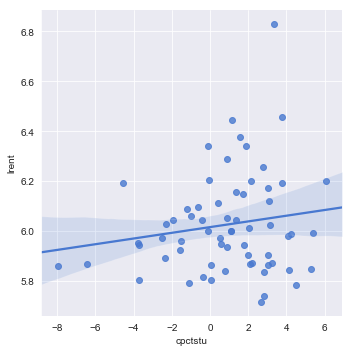

In [175]:
eda.run()

## Segmentation

In [176]:
df_90 = df[df['y90']==True]

In [177]:
segmentation_vars = ['lrent', 'lavginc']

In [178]:
X = df_90[segmentation_vars]

In [179]:
wcss = []
for i in range(1,11):
        kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state=2015)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        
        

In [180]:
cluster_df = pd.DataFrame(wcss) 
cluster_df = cluster_df.rename(columns = {0:'wcss'})
cluster_df['num_of_clusters'] = cluster_df.index + 1
cluster_df


,wcss,num_of_clusters
0,6.649945,1
1,3.615303,2
2,2.448714,3
3,1.768557,4
4,1.201129,5
5,0.906423,6
6,0.780064,7
7,0.608159,8
8,0.526800,9
9,0.444848,10


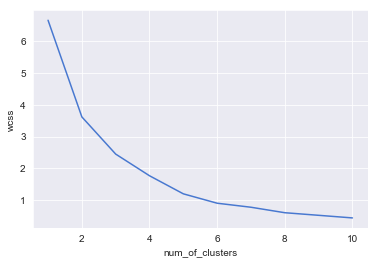

In [181]:
sns_plot = sns.lineplot(x="num_of_clusters", y="wcss", data=cluster_df).get_figure()
sns_plot.savefig("kmeans_elbow_plot.png")

In [195]:
kmeans = KMeans(n_clusters=4, init = 'k-means++', random_state=2015)
df_90['y_means'] = kmeans.fit_predict(df_90)

/Users/jjespinoza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



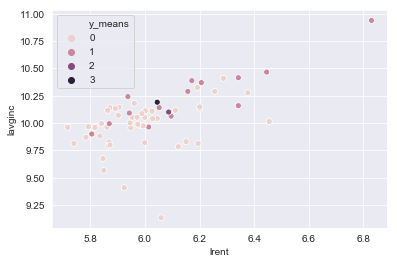

In [196]:
sns_plot = sns.scatterplot(x="lrent", y="lavginc", hue="y_means",data=df_90).get_figure()
sns_plot.savefig("kmeans_scatter.png")

In [206]:
stats = df_90[['lrent','lavginc','y_means']].groupby(['y_means']).mean()

In [207]:
stats

,lrent,lavginc
y_means,,
0,5.985896,9.977012
1,6.157958,10.244238
2,6.086775,10.100450
3,6.045005,10.190580


In [208]:
stats['diff'] = stats['lavginc']- stats['lrent']

In [214]:
stats.sort_values(by='lavginc')

,lrent,lavginc,diff
y_means,,,
0,5.985896,9.977012,3.991116
2,6.086775,10.100450,4.013675
3,6.045005,10.190580,4.145575
1,6.157958,10.244238,4.086280
